# Opdracht classificatie - Naive Bayes & NLP

Sinds enkele jaren schieten de Natural Language Processing toepassingen als paddenstoelen uit de grond. Eén van de belangrijkste redenen daarvoor is de steeds groter wordende beschikbaarheid van tekstuele data aangeleverd door bijvoorbeeld social media. 

In deze opdracht zal NLP toegepast worden in het kader van sentiment analysis.
De bedoeling van sentiment analysis is om uit een tekstueel bericht zoals een email, sms, twitter bericht, Trip Advisor review het sentiment te voorspellen.
Bedrijven weten bijvoorbeeld graag wat het sentiment is in de berichten die online over hen verschijnen.


De opdracht bestaat uit vier deelopdrachten.
- De eerste deelopdracht gaat rond het uitvoeren van pure sentiment analysis van tekstberichten.
- Bij de tweede deelopdracht is het de bedoeling om op basis van een review die een klant over een gekocht product heeft geschreven de rating te voorspellen die de klant aan het gekochte product toekent. 
- De derde deelopdracht gaat over het opsporen van cyber trolls aan de hand van de berichten die ze op het internet plaatsen.
- De vierde deelopdracht bestaat uit het detecteren van sarcasme in tekstberichten 

Telkens wordt het bag-of-words model gebruikt om tekst voor te stellen en vervolgens worden verschillende classifiers getraind om het sentiment/rating te voorspellen.

Het bag-of-words model beschrijft het voorkomen van woorden binnen een document en doet dit op bais van een vocabulair van gekende woorden en meet de aanwezigheid van deze gekende woorden.
De grote beperking van het bag-of-words model is dat het enkel rekening houdt met welke woorden in een bericht voorkomen en niet met de volgorde ervan. Daardoor is het bag-of-words model heel beperkt in het capteren van de context waarin woorden in een bericht voorkomen .
Tijdens de module deep learning zullen we afstappen van het bag-of-words model en gebruik maken van word embeddings in combinatie met LSTM neurale netwerken. Op deze manier kunnen we modellen trainen die wel rekening houden met de context en woordvolgordes.


In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import seaborn as sns

## Deel 1 - Sentiment analysis 

Bij deze deelopdracht is het de bedoeling om het sentiment van tekstberichten te classificeren in negatief of positief.
De training set en de test set zijn te vinden in de bestanden *sentiment_train.csv* en *sentiment_test.csv*.

De stappen die doorlopen dienen te worden zijn:

1. Vooranalyse van de data.
2. Preprocessing van de tekst.
3. Omzetten naar bag-of-words.
4. Trainen van de classifiers.
5. Testen van de getrainde classifiers + uitvoeren van hyperparameter tuning.

In [4]:
# Importeren van de datasets

dataset_train = pd.read_csv('sentiment_train.csv')
dataset_test = pd.read_csv('sentiment_test.csv')

# Opsplitsen in features en targets
X_train = dataset_train['text'].values
y_train = dataset_train['sentiment'].values

X_test = dataset_test['text'].values
y_test = dataset_test['sentiment'].values

print(X_train.shape)
print(y_train.shape)

dataset_train.head()

(5918,)
(5918,)


,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,0,"Oh, and Brokeback Mountain was a terrible movie."
2,1,"He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC..."
3,1,1st and 2nd Harry Potter movies are clearly th...
4,0,Mission Impossible 3 was quite boring.


### 1. Vooranalyse van de data

- Onderzoek of er ontbrekende waarden in de datasets voorkomen.
- Is de dataset gebalanceerd?
- Onderzoek of er een correlatie te vinden is tussen de lengte van een bericht enerzijds en het sentiment anderzijds. Dit mag grafisch (via bijvoorbeeld een boxplot) of via correlatiecoëfficiënten. 

In [445]:
# Vooranalyse van de data
# onderzoek of er ontbrekende waarden in de datasets voorkomen
print(dataset_train.isnull().sum())
print('No missing values in training set.')
# test
print(dataset_test.isnull().sum())
print('No missing values in test set.')

sentiment         0
text              0
Message Length    0
dtype: int64
No missing values in training set.
sentiment    0
text         0
dtype: int64
No missing values in test set.


1    3383
0    2535
Name: sentiment, dtype: int64

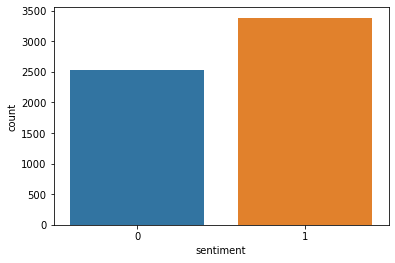

In [6]:
# gebalanceerdheid controleren
sns.countplot(x='sentiment',data=dataset_train)

dataset_train['sentiment'].value_counts()

Not perfectly balanced. There are approximately 850 samples more in the positive class than in the negative class. The classifier has a preference for the class with sentiment (class 1).

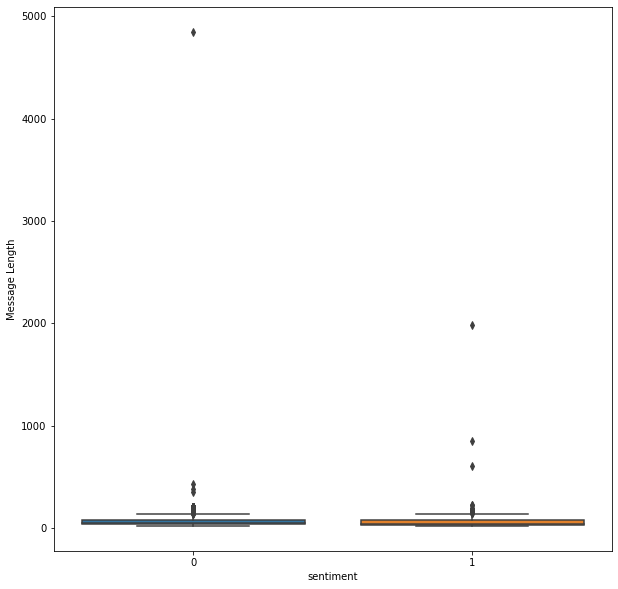

In [446]:
# Onderzoek of er een correlatie te vinden is tussen de lengte van een bericht enerzijds en het sentiment anderzijds. Dit mag grafisch (via bijvoorbeeld een boxplot) of via correlatiecoëfficiënten.

dataset_train['Message Length']=dataset_train['text'].apply(len)

plt.figure(figsize=(10,10))
sns.boxplot(x='sentiment', y='Message Length', data=dataset_train)

In [8]:
dataset_train.corr()

,sentiment,Message Length
sentiment,1.000000,-0.046637
Message Length,-0.046637,1.000000


Correlation coefficient of -0.04 indicates that the relationship is negative and has very little, almost no correlation. This means that the sentiment and the message length has no correlation.

### 2. Preprocessing van de tekst

- Kuis de teksten op: verwijder stopwoorden en niet-letters, zet alles om naar lowercase, ... 
- Pas stemming toe.

In [7]:
# Preprocessing van de tekst

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

In [8]:
# Convert training and test set to bag of words
language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

### 3. Omzetten naar bag-of-words

Maak gebruik van de CountVectorizer en TfidfTransformer om een bag-of-words model te creëren. 

Meer info: 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer



In [9]:
# Omzetten naar bag-of-words

# Make sparse features vectors 

# create instance 
count_vect = CountVectorizer()

# train the object on the training set
X_train_bag_of_words = count_vect.fit(X_train)

# apply  the function on train
X_train_bag_of_words = count_vect.transform(X_train)
# apply  the function on test
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

  (0, 88)	1
  (0, 149)	1
  (0, 247)	1
  (0, 314)	1
  (0, 1502)	1
  (1, 166)	1
  (1, 939)	1
  (1, 942)	1
  (1, 987)	1
  (1, 1389)	1
  (2, 12)	1
  (2, 166)	1
  (2, 596)	1
  (2, 637)	1
  (2, 834)	1
  (2, 860)	1
  (2, 939)	1
  (2, 1576)	1
  (3, 120)	1
  (3, 234)	1
  (3, 554)	1
  (3, 631)	1
  (3, 942)	1
  (3, 960)	1
  (3, 1080)	1
  :	:
  (5914, 787)	1
  (5914, 834)	1
  (5914, 923)	1
  (5914, 927)	1
  (5914, 1370)	1
  (5915, 166)	1
  (5915, 397)	1
  (5915, 860)	1
  (5915, 939)	1
  (5916, 247)	1
  (5916, 314)	1
  (5916, 798)	1
  (5916, 860)	1
  (5916, 948)	1
  (5916, 1035)	1
  (5916, 1502)	1
  (5916, 1560)	1
  (5917, 43)	1
  (5917, 298)	1
  (5917, 609)	1
  (5917, 631)	1
  (5917, 634)	1
  (5917, 798)	1
  (5917, 1080)	1
  (5917, 1513)	1


### 4. Trainen van de classifiers

Train drie verschillende classifiers op de bag-of-words data: naive bayes classifier, logistic regression classifier en een Support Vector Machine classifier.



In [10]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)



MultinomialNB(alpha=1)

In [11]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       440
           1       0.97      0.99      0.98       560

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

[[422  18]
 [  5 555]]
97.7


In [12]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

LogisticRegression(C=10)

In [13]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[434   6]
 [  1 559]]
99.3


In [14]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1)
SVMlinear.fit(X_train_tf, y_train)

SVC(C=0.1, kernel='linear')

In [15]:
# test SVM
y_pred = SVMlinear.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 



              precision    recall  f1-score   support

           0       1.00      0.98      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[432   8]
 [  0 560]]
99.2


Logistic regression has the highest accuracy.

### 5. Testen en hyperparameter tuning

- Voer hyperparameter tuning uit via grid-search, random search of Bayes Optimization.
- Welke classifier heeft jouw voorkeur? Beargumenteer in de context van accuracy, f1-score en berekeningstijd.
- Stel dat er continu bijgeleerd moet worden op nieuwe data (dagelijks komen er nieuwe reviews/beoordelingen bij), welke methode geniet dan jouw voorkeur?
- Welke classifier valt te verkiezen als je zo weinig mogelijk false positives wilt? (false positive = een tekst die verkeerdelijk als positief wordt geklassificeerd. 

In [18]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


Best accuracy :  0.9827639715987173
Best parameters : {'alpha': 1}
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       440
           1       0.97      0.99      0.98       560

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

[[422  18]
 [  5 555]]
97.7


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [26]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best accuracy :  0.9832718866372712
Best parameters : {'alpha': 1}
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       440
           1       0.97      0.99      0.98       560

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

[[422  18]
 [  5 555]]
97.7


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [29]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 970 tasks      | elapsed:   19.0s


Best accuracy :  0.9957758818140174
Best parameters : {'C': 100, 'class_weight': 'balanced', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[436   4]
 [  2 558]]
99.4


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.7s finished
C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [30]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

              

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s


Best accuracy :  0.9952691250572606
Best parameters : {'C': 7.911338786767389, 'class_weight': None, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[434   6]
 [  1 559]]
99.3


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.4s finished


In [31]:
# hyperparameter tuning SVM - Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC()

paramaters = [ 
        {'kernel': ['linear'], 
         'C': np.linspace(0.01,20,10), 
         'degree': [2,3,4], 
         'class_weight': [None, 'balanced']},
        {'kernel': ['rbf', 'poly', 'sigmoid'], 
         'C': np.linspace(0.01,20,10), 
         'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2], 
         'degree': [2,3,4], 
         'class_weight': [None, 'balanced']},
]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', 
                           cv = 20,
                           n_jobs = -1,
                           verbose =5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )


y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 960 candidates, totalling 19200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

Best accuracy :  0.9957758818140174
Best parameters : {'C': 6.673333333333333, 'class_weight': None, 'degree': 2, 'gamma': 0.2, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[436   4]
 [  2 558]]
99.4


In [33]:
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform


#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': uniform(0.01, 20), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': uniform(0.01, 20), 
     'gamma': uniform(0.001, 0.2), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.9s finished


Best accuracy :  0.9962817847433231
Best parameters : {'C': 10.723832850344332, 'class_weight': 'balanced', 'degree': 3, 'gamma': 0.0999159800285068, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       440
           1       0.99      1.00      0.99       560

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[436   4]
 [  2 558]]
99.4


- Welke classifier heeft jouw voorkeur? Beargumenteer in de context van accuracy, f1-score en berekeningstijd.

In general if we compare the 3 classifiers, we can see that they all are doing well when it comes to the scores with a minimum of 97% which is ideal for the model. Therefore, the execution time is important for deciding the most suitable classifier. When it comes to execution time the order is as follows: Naive Bayes, Logistic Regression and SVM.Eventhough the accuracy rate of SVM is similar as Logistic Regression, the execution is the slowest. Therefore SVM is not an option. On the other hand, is Naive Bayes the fastest with an accuracy rate of 97.7%, slightly less than the logistic regression with 99.4%. This means that there are always upsides and downsides when it comes to choosing classifiers. At last, if I had to choose then the logistic regression classifier will be my preference for this case.

- Stel dat er continu bijgeleerd moet worden op nieuwe data (dagelijks komen er nieuwe reviews/beoordelingen bij), welke methode geniet dan jouw voorkeur?

Naive bayes as this is the fastest for processing new data.

- Welke classifier valt te verkiezen als je zo weinig mogelijk false positives wilt? (false positive = een tekst die verkeerdelijk als positief wordt geklassificeerd. 

By evaluating the model we can see in the confusion matrix that the logistic regression (grid search) and SVM (grid search and random search) are the most suitable classifier when it comes to the least false positives. Both have 4 samples while Naive Bayes has 18.

## Deel 2 - Webshop women clothing

Het bestand 'Womens_Clothing_Reviews.csv' bevat een collectie reviews over aangekochte kledij bij een bepaalde webwinkel. Deze dataset bestaat uit 23486 rijen met telkens 10 variabelen:

- clothing ID: categorische variabele die verwijst naar het gereviewde product.
- Age: de leeftijd van de reviewer.
- Titel: titel van de review.
- Review text: de review zelf.
- Rating: Een score die door de reviewer aan het product werd toegekend. De slechtst mogelijke score is 1, de best is 5.
- Recommended IND: binaire variabele die aanduidt of de klant het product aanbeveelt. 1 = aanbevolen, 0 = niet aanbevolen.
- Positive feedback count: getal dat aangeeft hoeveel andere klanten deze review positief vonden.
- Division name: categorische variabele van de afdeling waartoe het product behoort.
- Department name: categorische variabele die het type product weergeeft.
- Class name: categorische variabele die de subcategorie weergeeft.



In [56]:
# Inlezen van de dataset

dataset = pd.read_csv('./Womens_Clothing_Reviews.csv')

# verwijder kolom unnamed
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

print(dataset.shape)
dataset.head()

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1. Vooranalyse van de data

- Ga op zoek naar mogelijks ontbrekende waarden en verwijder de volledige rij via listwise deletion. Hoeveel reviews blijven nog over?
- Welke leeftijdscategorie heeft het meest reviews gegeven (visualiseer via een histogram: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html).

- Stop alle reviews in een matrix X, de targets (= ratings) in een vector y.

- Creëer een nieuwe vector ys (simplified y). positief sentiment = 1, neutraal sentiment = 0, negatief sentiment=-1. Bij een positief sentiment is de rating groter dan 3, bij een negatief sentiment kleiner dan 3 en tot slotte bij een neutraal sentiment gelijk aan 3.

- In welke mate is de vector y gebalanceerd en in welke mate de vector ys? Visualiseer met een histogram.

- Is er een verband tussen de lengte van een review en het sentiment?



- Ga op zoek naar mogelijks ontbrekende waarden en verwijder de volledige rij via listwise deletion. Hoeveel reviews blijven nog over?

In [57]:
# Vooranalyse van de data

# total reviews
print(dataset.shape)
#Verwijderen van rijen met NaN waarden 
dataset.dropna(axis=0,inplace=True)
print(dataset.shape)


(23486, 10)
(19662, 10)


In total there are 23486 reviews. As you can see above we have deleted the rows with missing values and it has decreased to 19662. Therefore in total there are still 19662 review remaining.

- Welke leeftijdscategorie heeft het meest reviews gegeven (visualiseer via een histogram: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html).

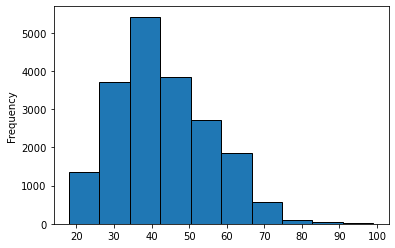

In [114]:
dataset['Age'].plot.hist(edgecolor='k')


The age category between 34-41 has the most reviews.

- Stop alle reviews in een matrix X, de targets (= ratings) in een vector y.

In [115]:
X = dataset['Review Text'].values
y = dataset['Rating'].values

print(X)
print(y)

print(X.shape)
print(y.shape)

['I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
 'This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!'
 ...
 "This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with 

- Creëer een nieuwe vector ys (simplified y). positief sentiment = 1, neutraal sentiment = 0, negatief sentiment=-1. Bij een positief sentiment is de rating groter dan 3, bij een negatief sentiment kleiner dan 3 en tot slotte bij een neutraal sentiment gelijk aan 3

In [116]:
# create a list of our conditions

conditions = [
    (dataset['Rating'] > 3),
    (dataset['Rating'] < 3),
    (dataset['Rating'] == 3)
]

# create a list of the values we want to assign for each conditon
values = [1, -1, 0]

# create a new column and use np.select to assign to it using our lists as arguments
dataset['Sentiment'] = np.select(conditions, values)

# display updated DataFrame
dataset.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,-1
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,1


In [117]:
ys = dataset['Sentiment'].values

- In welke mate is de vector y gebalanceerd en in welke mate de vector ys? Visualiseer met een histogram.

(array([  691.,     0.,  1360.,     0.,     0.,  2464.,     0.,  4289.,
            0., 10858.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

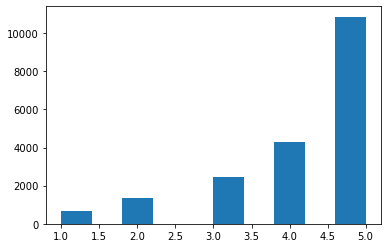

In [63]:
plt.hist(y)

(array([ 2051.,     0.,     0.,     0.,     0.,  2464.,     0.,     0.,
            0., 15147.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

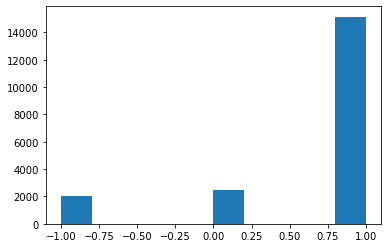

In [64]:
plt.hist(ys)

(array([ 2051.,     0.,     0.,     0.,     0.,  2464.,     0.,     0.,
            0., 15147.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

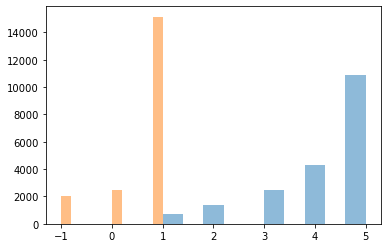

In [65]:
#plt.hist([y, ys])
plt.hist(y, alpha=0.5)
plt.hist(ys, alpha=0.5)

As you can see from the histograms, both plots are not balanced. Moreover, the higher the rating, the higher the column is.

- Is er een verband tussen de lengte van een review en het sentiment?

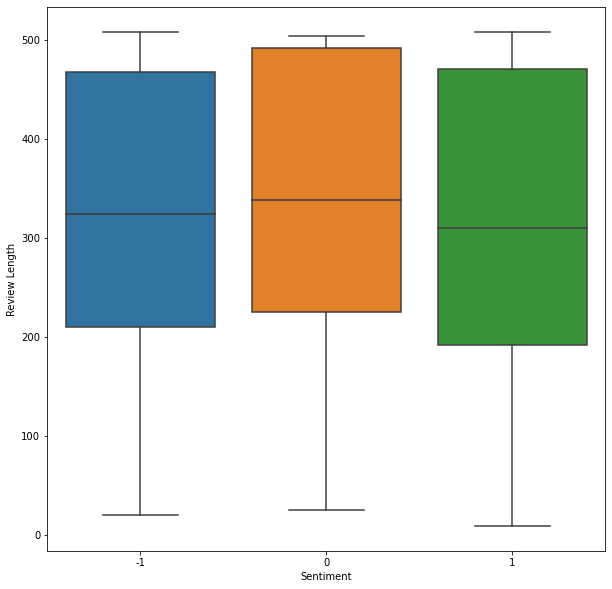

In [119]:
dataset['Review Length']=dataset['Review Text'].apply(len)

plt.figure(figsize=(10,10))
sns.boxplot(x='Sentiment', y='Review Length', data=dataset)

From the plot we can see that the rating 3 and 4 have a longer review

In [121]:
dataset.corr() 

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Sentiment,Review Length
Clothing ID,1.000000,0.012547,-0.013529,-0.012949,0.041300,-0.011054,0.088266
Age,0.012547,1.000000,0.034910,0.035407,0.041167,0.028176,0.022189
Rating,-0.013529,0.034910,1.000000,0.793145,-0.056659,0.923051,-0.054845
Recommended IND,-0.012949,0.035407,0.793145,1.000000,-0.059452,0.839159,-0.027640
Positive Feedback Count,0.041300,0.041167,-0.056659,-0.059452,1.000000,-0.056920,0.192506
Sentiment,-0.011054,0.028176,0.923051,0.839159,-0.056920,1.000000,-0.034135
Review Length,0.088266,0.022189,-0.054845,-0.027640,0.192506,-0.034135,1.000000


Correlation coefficient of -0.03 indicates that the relationship is negative and has very little, almost no correlation. This means that the sentiment and the message length has no correlation.

### 2. Preprocessing van de tekst

- Kuis de teksten op: verwijder stopwoorden en niet-letters, zet alles om naar lowercase, ... 
- Pas stemming toe.

In [69]:
# Preprocessing van de tekst.

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

### 3. Omzetten naar bag-of-words


Creëer een training set en een test set. Zorg ervoor dat er 5000 reviews in de test set zitten.

Maak gebruik van de CountVectorizer en TfidfTransformer om een bag-of-words model te creëren. 

Meer info:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [70]:
# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=5000, random_state=0)



In [71]:
# Convert training and test set to bag of words
language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

In [72]:
print(X_train[0])

 bought moss navi fit perfect love style roll waist excel qualiti bought peachi color top eleph wear moss color one receiv lot compliment 


In [73]:
# Omzetten naar bag-of-words

# Make sparse features vectors 

# create instance 
count_vect = CountVectorizer()

# train the object on the training set
X_train_bag_of_words = count_vect.fit(X_train)

# apply  the function on train
X_train_bag_of_words = count_vect.transform(X_train)
# apply  the function on test
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)


  (0, 780)	2
  (0, 1311)	2
  (0, 1379)	1
  (0, 2142)	1
  (0, 2295)	1
  (0, 2495)	1
  (0, 3913)	1
  (0, 3926)	1
  (0, 4317)	2
  (0, 4416)	1
  (0, 4638)	1
  (0, 4886)	1
  (0, 4931)	1
  (0, 5334)	1
  (0, 5431)	1
  (0, 5677)	1
  (0, 6580)	1
  (0, 7019)	1
  (0, 7496)	1
  (0, 7556)	1
  (1, 1311)	1
  (1, 1999)	1
  (1, 2916)	2
  (1, 3522)	1
  (1, 3755)	1
  :	:
  (14661, 1803)	1
  (14661, 1812)	1
  (14661, 2199)	1
  (14661, 2432)	1
  (14661, 2495)	1
  (14661, 2689)	1
  (14661, 2875)	1
  (14661, 3430)	1
  (14661, 3755)	1
  (14661, 3845)	1
  (14661, 3926)	2
  (14661, 4682)	1
  (14661, 4742)	1
  (14661, 4916)	1
  (14661, 4931)	1
  (14661, 5431)	1
  (14661, 5733)	1
  (14661, 5931)	1
  (14661, 6035)	1
  (14661, 6129)	1
  (14661, 6580)	1
  (14661, 6998)	1
  (14661, 7019)	2
  (14661, 7289)	1
  (14661, 7366)	1


### 4. Trainen van de classifiers

Train drie verschillende classifiers op de bag-of-words data: naive bayes classifier, logistic regression classifier en een Support Vector Machine classifier.




In [74]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1)

In [75]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       551
           0       0.00      0.00      0.00       600
           1       0.77      1.00      0.87      3849

    accuracy                           0.77      5000
   macro avg       0.59      0.34      0.30      5000
weighted avg       0.70      0.77      0.67      5000

[[   6    1  544]
 [   0    0  600]
 [   0    0 3849]]
77.10000000000001


In [76]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [77]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

          -1       0.57      0.43      0.49       551
           0       0.38      0.33      0.35       600
           1       0.89      0.94      0.91      3849

    accuracy                           0.81      5000
   macro avg       0.61      0.57      0.59      5000
weighted avg       0.79      0.81      0.80      5000

[[ 238  147  166]
 [ 101  198  301]
 [  79  171 3599]]
80.7


In [78]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1)
SVMlinear.fit(X_train_tf, y_train)

SVC(C=0.1, kernel='linear')

In [79]:
# test SVM
y_pred = SVMlinear.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


              precision    recall  f1-score   support

          -1       0.90      0.05      0.09       551
           0       0.00      0.00      0.00       600
           1       0.77      1.00      0.87      3849

    accuracy                           0.78      5000
   macro avg       0.56      0.35      0.32      5000
weighted avg       0.69      0.78      0.68      5000

[[  26    0  525]
 [   3    0  597]
 [   0    0 3849]]
77.5


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression has the highest accuracy.

### 5. Testen en hyperparameter tuning

- Voer hyperparameter tuning uit via grid-search, random search of Bayes Optimization.
- Welke classifier heeft jouw voorkeur? Beargumenteer in de context van accuracy, f1-score en berekeningstijd.
- Bekijk enkele verkeerd geklassificeerde reviews. Is er een verklaring voor te vinden?


In [26]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


Best accuracy :  0.7876826598168849
Best parameters : {'alpha': 0.01}
              precision    recall  f1-score   support

          -1       0.67      0.17      0.27       551
           0       0.42      0.09      0.14       600
           1       0.80      0.99      0.89      3849

    accuracy                           0.79      5000
   macro avg       0.63      0.41      0.43      5000
weighted avg       0.74      0.79      0.73      5000

[[  94   42  415]
 [  28   52  520]
 [  18   30 3801]]
78.94


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


In [27]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best accuracy :  0.7876144535834175
Best parameters : {'alpha': 0.01}
              precision    recall  f1-score   support

          -1       0.67      0.17      0.27       551
           0       0.42      0.09      0.14       600
           1       0.80      0.99      0.89      3849

    accuracy                           0.79      5000
   macro avg       0.63      0.41      0.43      5000
weighted avg       0.74      0.79      0.73      5000

[[  94   42  415]
 [  28   52  520]
 [  18   30 3801]]
78.94


In [28]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.8min finished


Best accuracy :  0.8179655292906238
Best parameters : {'C': 1, 'class_weight': None, 'solver': 'saga'}
              precision    recall  f1-score   support

          -1       0.65      0.39      0.49       551
           0       0.39      0.24      0.30       600
           1       0.86      0.96      0.91      3849

    accuracy                           0.81      5000
   macro avg       0.64      0.53      0.57      5000
weighted avg       0.78      0.81      0.79      5000

[[ 216  119  216]
 [  79  143  378]
 [  36  102 3711]]
81.39999999999999


In [29]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.0min finished


Best accuracy :  0.8200806844329787
Best parameters : {'C': 1.7440212848786218, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

          -1       0.64      0.41      0.50       551
           0       0.39      0.27      0.32       600
           1       0.87      0.96      0.91      3849

    accuracy                           0.81      5000
   macro avg       0.63      0.55      0.58      5000
weighted avg       0.79      0.81      0.79      5000

[[ 228  125  198]
 [  86  159  355]
 [  43  121 3685]]
81.44


In [483]:
# hyperparameter tuning SVM - Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC()

paramaters = [ 
        {'kernel': ['linear'], 
         'C': [0.01, 0.1, 1, 10, 100], 
         'degree': [2], 
         'class_weight': [None, 'balanced']},
        {'kernel': ['rbf', 'poly', 'sigmoid'], 
         'C': [0.01, 0.1, 1, 10, 100], 
         'gamma': [0.001, 0.01, 0.1, 0.2], 
         'degree': [2], 
         'class_weight': [None, 'balanced']},
]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs = -1,
                           verbose =5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )


y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 162.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 234.5min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed: 239.9min finished


Best accuracy :  0.8217162374429563
Best parameters : {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

          -1       0.62      0.43      0.51       551
           0       0.40      0.24      0.30       600
           1       0.87      0.96      0.91      3849

    accuracy                           0.82      5000
   macro avg       0.63      0.54      0.57      5000
weighted avg       0.79      0.82      0.79      5000

[[ 236  120  195]
 [  91  147  362]
 [  53  103 3693]]
81.52000000000001


In [484]:
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform


#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'gamma': uniform(0.001, 0.2), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.9min finished


Best accuracy :  0.8215798117949346
Best parameters : {'C': 1, 'class_weight': None, 'degree': 4, 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.62      0.43      0.51       551
           0       0.40      0.24      0.30       600
           1       0.87      0.96      0.91      3849

    accuracy                           0.82      5000
   macro avg       0.63      0.54      0.57      5000
weighted avg       0.79      0.82      0.79      5000

[[ 236  120  195]
 [  91  147  362]
 [  53  103 3693]]
81.52000000000001


- Welke classifier heeft jouw voorkeur? Beargumenteer in de context van accuracy, f1-score en berekeningstijd.


In general if we compare the 3 classifiers, we can see that there are differences in scores. Based on the scores the order is as follows: SVM (81,52%), Logistic regression (81,44%) and Naive Bayes (78,94%). Moreover, if we take the execution time into consideration then the logistic regression would be the most suitable classifier for this case.



- Bekijk enkele verkeerd geklassificeerde reviews. Is er een verklaring voor te vinden?

In [30]:
indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

In [31]:
wrong_predictions = dataset.iloc[indices,:]
wrong_predictions

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment,Review Length
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,500
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,-1,488
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,1,496
13,767,44,Runs big,Bought the black xs to go under the larkspur m...,5,1,0,Initmates,Intimate,Intimates,1,377
23,1077,34,"Like it, but don't love it.",Cute little dress fits tts. it is a little hig...,3,1,0,General,Dresses,Dresses,0,202
...,...,...,...,...,...,...,...,...,...,...,...,...
5963,873,41,Flattering tank,I purchased the coral color. i'm usually betwe...,5,1,1,General,Tops,Knits,1,173
5964,1004,23,"Love the structure, not the length",I got this skirt earlier this week and wore it...,4,1,4,General Petite,Bottoms,Skirts,1,489
5974,839,56,Darling summer top,I usually try to avoid paying full price for i...,5,1,1,General,Tops,Blouses,1,284
5978,1086,29,"Very cute dress, but odd sizing",The pattern and fabric are very nice! i'm usua...,4,0,1,General,Dresses,Dresses,1,219


In [32]:
wrong_predictions['Review Text']

2       I had such high hopes for this dress and reall...
5       I love tracy reese dresses, but this one is no...
6       I aded this in my basket at hte last mintue to...
13      Bought the black xs to go under the larkspur m...
23      Cute little dress fits tts. it is a little hig...
                              ...                        
5963    I purchased the coral color. i'm usually betwe...
5964    I got this skirt earlier this week and wore it...
5974    I usually try to avoid paying full price for i...
5978    The pattern and fabric are very nice! i'm usua...
5979    This is a perfect casual too to pair with jns ...
Name: Review Text, Length: 928, dtype: object

### 6. Uitbreidingen

- Bij niet gebalanceerde data kan het helpen om de data op te splitsen via stratified sampling. Zoek het verschil uit tussen stratified sampling en random sampling. Meer info: http://statl6.blogspot.com/2015/11/other-effective-sampling-methods.html.
Pas deze stratified sampling toe via StratifiedShuffleSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html. Train de modellen opnieuw en vergelijk de accuracy en f1-score met de deze bekomen via het trainen van de modellen op random sampled data.

- Voorspel in plaats van het sentiment (negatief, neutraal, positief) de rating zelf.

- Gebruik andere features om betere sentiment predicties te bekomen. Dit kan door andere features (zoals de recommended IND) mee te nemen als input features. Een andere optie is om de output van de reeds getrainde text classifier als nieuwe feature te zien en daarmee samen met andere features (bijvoorbeeld recommended IND, lengte review, leeftijd) een nieuwe classifier te trainen die het sentiment of rating voorspelt.


- Bij niet gebalanceerde data kan het helpen om de data op te splitsen via stratified sampling. Zoek het verschil uit tussen stratified sampling en random sampling. Meer info: http://statl6.blogspot.com/2015/11/other-effective-sampling-methods.html.
Pas deze stratified sampling toe via StratifiedShuffleSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html. Train de modellen opnieuw en vergelijk de accuracy en f1-score met de deze bekomen via het trainen van de modellen op random sampled data.

In [80]:
y = ys
print(y)

[0 1 1 ... 0 0 1]


In [81]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=5000, random_state=0)
sss.get_n_splits(X, y)
print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=5000,
            train_size=None)
TRAIN: [ 8619 13698 12159 ...  2788 17404  5926] TEST: [10181 15066  3865 ...  3520 17056  7081]
TRAIN: [ 5296 12948  4483 ... 11925 16813 10017] TEST: [18309  7973  6250 ... 17115  6955 10745]
TRAIN: [  120  1728 17998 ... 17681 18365  1331] TEST: [14940   193  5163 ...  6177 13093  6135]
TRAIN: [ 7428  9917   725 ...  6097 14217 17586] TEST: [ 8128 15355  6112 ... 13610 15551 13318]
TRAIN: [19007  4916 10409 ... 17132  7165 16981] TEST: [10392  1117 10688 ...  5696 11158  9694]


In [82]:
# Convert training and test set to bag of words
language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

In [83]:
# Make sparse features vectors

# Omzetten naar bag-of-words

# create instance 
count_vect = CountVectorizer()

# train the object on the training set
X_train_bag_of_words = count_vect.fit(X_train)

# apply  the function on train
X_train_bag_of_words = count_vect.transform(X_train)
# apply  the function on test
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)


  (0, 424)	1
  (0, 524)	1
  (0, 1129)	1
  (0, 1299)	1
  (0, 2010)	1
  (0, 2342)	2
  (0, 2792)	1
  (0, 2818)	1
  (0, 3097)	1
  (0, 3902)	1
  (0, 4324)	1
  (0, 5377)	1
  (0, 5914)	1
  (0, 7453)	1
  (1, 1129)	1
  (1, 1299)	1
  (1, 1807)	1
  (1, 3097)	1
  (1, 3324)	1
  (1, 3655)	1
  (1, 5156)	1
  (1, 5964)	1
  (1, 6245)	1
  (1, 7216)	1
  (1, 7587)	1
  :	:
  (14660, 5644)	1
  (14660, 5692)	1
  (14660, 6175)	1
  (14660, 6522)	2
  (14660, 7587)	1
  (14661, 21)	1
  (14661, 590)	1
  (14661, 710)	1
  (14661, 903)	1
  (14661, 1477)	1
  (14661, 1627)	1
  (14661, 1797)	1
  (14661, 2010)	2
  (14661, 2426)	1
  (14661, 2454)	1
  (14661, 2482)	2
  (14661, 3902)	1
  (14661, 4618)	1
  (14661, 5608)	1
  (14661, 5776)	1
  (14661, 6144)	1
  (14661, 6849)	1
  (14661, 7222)	1
  (14661, 7667)	1
  (14661, 7691)	1


### Evaluate the model

In [84]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1)

In [85]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

          -1       0.88      0.01      0.03       521
           0       0.00      0.00      0.00       627
           1       0.77      1.00      0.87      3852

    accuracy                           0.77      5000
   macro avg       0.55      0.34      0.30      5000
weighted avg       0.69      0.77      0.67      5000

[[   7    1  513]
 [   1    0  626]
 [   0    0 3852]]
77.18


In [86]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [87]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

          -1       0.53      0.44      0.48       521
           0       0.41      0.29      0.34       627
           1       0.89      0.95      0.92      3852

    accuracy                           0.81      5000
   macro avg       0.61      0.56      0.58      5000
weighted avg       0.79      0.81      0.80      5000

[[ 227  133  161]
 [ 136  183  308]
 [  69  130 3653]]
81.26


In [88]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1)
SVMlinear.fit(X_train_tf, y_train)

SVC(C=0.1, kernel='linear')

In [89]:
# test SVM
y_pred = SVMlinear.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


              precision    recall  f1-score   support

          -1       0.81      0.06      0.10       521
           0       0.00      0.00      0.00       627
           1       0.78      1.00      0.87      3852

    accuracy                           0.78      5000
   macro avg       0.53      0.35      0.33      5000
weighted avg       0.68      0.78      0.68      5000

[[  29    0  492]
 [   7    0  620]
 [   0    0 3852]]
77.62


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testen en hyperparameter tuning

In [90]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


Best accuracy :  0.7894561003081659
Best parameters : {'alpha': 0.01}
              precision    recall  f1-score   support

          -1       0.63      0.17      0.27       521
           0       0.38      0.08      0.13       627
           1       0.81      0.99      0.89      3852

    accuracy                           0.79      5000
   macro avg       0.60      0.41      0.43      5000
weighted avg       0.73      0.79      0.73      5000

[[  91   53  377]
 [  40   49  538]
 [  14   27 3811]]
79.02


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


In [91]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


Best accuracy :  0.7884328214154313
Best parameters : {'alpha': 0.1}
              precision    recall  f1-score   support

          -1       0.70      0.15      0.24       521
           0       0.34      0.04      0.08       627
           1       0.80      1.00      0.89      3852

    accuracy                           0.79      5000
   macro avg       0.61      0.40      0.40      5000
weighted avg       0.73      0.79      0.72      5000

[[  76   43  402]
 [  27   28  572]
 [   6   12 3834]]
78.75999999999999


In [92]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.6min finished


Best accuracy :  0.8181013044076264
Best parameters : {'C': 1, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

          -1       0.59      0.39      0.47       521
           0       0.41      0.20      0.27       627
           1       0.86      0.97      0.91      3852

    accuracy                           0.82      5000
   macro avg       0.62      0.52      0.55      5000
weighted avg       0.78      0.82      0.79      5000

[[ 204  110  207]
 [ 107  127  393]
 [  35   71 3746]]
81.54


In [93]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Best accuracy :  0.8166007152123893
Best parameters : {'C': 2.5042558060299855, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

          -1       0.57      0.43      0.49       521
           0       0.42      0.25      0.31       627
           1       0.88      0.96      0.92      3852

    accuracy                           0.82      5000
   macro avg       0.62      0.55      0.57      5000
weighted avg       0.79      0.82      0.80      5000

[[ 226  125  170]
 [ 125  155  347]
 [  46   92 3714]]
81.89999999999999


In [94]:
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform


#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'gamma': uniform(0.001, 0.2), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.8min finished


Best accuracy :  0.816327982514446
Best parameters : {'C': 1, 'class_weight': None, 'degree': 2, 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.57      0.44      0.50       521
           0       0.42      0.22      0.29       627
           1       0.87      0.97      0.92      3852

    accuracy                           0.82      5000
   macro avg       0.62      0.54      0.57      5000
weighted avg       0.79      0.82      0.80      5000

[[ 230  120  171]
 [ 122  138  367]
 [  50   70 3732]]
82.0


In general there is a slight increase for the 3 classifiers. Therefore the use of StratifiedShuffleSplit is recommended as it improves the performance of the model.

- Voorspel in plaats van het sentiment (negatief, neutraal, positief) de rating zelf.

In [95]:
# Inlezen van de dataset

dataset = pd.read_csv('./Womens_Clothing_Reviews.csv')

# verwijder kolom unnamed
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
#Verwijderen van rijen met NaN waarden 
dataset.dropna(axis=0,inplace=True)

print(dataset.shape)
dataset.head()

(19662, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [96]:
X = dataset['Review Text'].values
y = dataset['Rating'].values

print(X)
print(y)

print(X.shape)
print(y.shape)

['I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
 'This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!'
 ...
 "This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with 

In [97]:
# Preprocessing van de tekst.

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

In [99]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=5000, random_state=0)
sss.get_n_splits(X, y)
print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=5000,
            train_size=None)
TRAIN: [ 4582 16410 10951 ...  5575  1668  5133] TEST: [  430  7563 16048 ...  9540  7920 17310]
TRAIN: [ 9009  2014 14354 ...  6782  7831  6013] TEST: [17985  3640 10105 ... 11760 14736  4901]
TRAIN: [ 1420 17234  7739 ...  4823 18817 13779] TEST: [12306 15253  5823 ...  4765 12923 15106]
TRAIN: [ 6446 19023 12143 ... 18254  5918 17758] TEST: [17267  8389 17226 ...  8518 13056 16730]
TRAIN: [ 3286  4332  5867 ...  3634  4439 12416] TEST: [ 5485 12406  3059 ... 12932  4341  9573]


In [100]:
# Convert training and test set to bag of words
language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

In [101]:
# Make sparse features vectors

# Omzetten naar bag-of-words

# create instance 
count_vect = CountVectorizer()

# train the object on the training set
X_train_bag_of_words = count_vect.fit(X_train)

# apply  the function on train
X_train_bag_of_words = count_vect.transform(X_train)
# apply  the function on test
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)


  (0, 187)	1
  (0, 438)	1
  (0, 451)	1
  (0, 766)	1
  (0, 960)	1
  (0, 1102)	1
  (0, 1109)	1
  (0, 1805)	1
  (0, 2268)	2
  (0, 2545)	1
  (0, 2692)	1
  (0, 3650)	1
  (0, 3683)	1
  (0, 3740)	1
  (0, 3839)	1
  (0, 4031)	1
  (0, 4060)	1
  (0, 4375)	1
  (0, 4656)	2
  (0, 4798)	1
  (0, 5208)	1
  (0, 5869)	1
  (0, 6019)	2
  (0, 6077)	1
  (0, 6243)	1
  :	:
  (14661, 1256)	1
  (14661, 2013)	1
  (14661, 2339)	1
  (14661, 2354)	1
  (14661, 2442)	1
  (14661, 2497)	2
  (14661, 2526)	1
  (14661, 2692)	1
  (14661, 2795)	1
  (14661, 3129)	1
  (14661, 3575)	1
  (14661, 3708)	2
  (14661, 3743)	1
  (14661, 3797)	1
  (14661, 3997)	1
  (14661, 4251)	1
  (14661, 4254)	1
  (14661, 4635)	1
  (14661, 4947)	2
  (14661, 5998)	1
  (14661, 6169)	1
  (14661, 6349)	1
  (14661, 6580)	1
  (14661, 7335)	3
  (14661, 7434)	1


In [102]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1)

In [103]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       176
           2       0.00      0.00      0.00       346
           3       0.17      0.01      0.02       626
           4       0.24      0.01      0.01      1091
           5       0.56      1.00      0.72      2761

    accuracy                           0.55      5000
   macro avg       0.19      0.20      0.15      5000
weighted avg       0.38      0.55      0.40      5000

[[   0    0   10    4  162]
 [   0    0   12    6  328]
 [   0    0    5   13  608]
 [   0    0    3    8 1080]
 [   0    0    0    2 2759]]
55.44


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [105]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           1       0.32      0.20      0.25       176
           2       0.26      0.21      0.23       346
           3       0.35      0.36      0.36       626
           4       0.39      0.33      0.36      1091
           5       0.76      0.85      0.80      2761

    accuracy                           0.61      5000
   macro avg       0.42      0.39      0.40      5000
weighted avg       0.58      0.61      0.59      5000

[[  36   51   59    8   22]
 [  40   72  134   59   41]
 [  24   93  225  161  123]
 [   4   43  154  355  535]
 [   8   19   68  325 2341]]
60.58


In [106]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1)
SVMlinear.fit(X_train_tf, y_train)

SVC(C=0.1, kernel='linear')

In [107]:
# test SVM
y_pred = SVMlinear.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       176
           2       0.00      0.00      0.00       346
           3       0.39      0.19      0.25       626
           4       0.62      0.00      0.01      1091
           5       0.59      1.00      0.74      2761

    accuracy                           0.58      5000
   macro avg       0.32      0.24      0.20      5000
weighted avg       0.51      0.58      0.44      5000

[[   0    0   49    0  127]
 [   0    0   83    0  263]
 [   0    0  118    3  505]
 [   0    0   51    5 1035]
 [   0    0    4    0 2757]]
57.599999999999994


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluate the model

In [108]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


Best accuracy :  0.590369167060083
Best parameters : {'alpha': 0.1}
              precision    recall  f1-score   support

           1       0.36      0.03      0.05       176
           2       0.25      0.03      0.06       346
           3       0.36      0.19      0.25       626
           4       0.35      0.12      0.18      1091
           5       0.63      0.97      0.77      2761

    accuracy                           0.59      5000
   macro avg       0.39      0.27      0.26      5000
weighted avg       0.50      0.59      0.50      5000

[[   5   20   56   19   76]
 [   5   12  100   52  177]
 [   3   13  120  105  385]
 [   0    3   50  135  903]
 [   1    0    9   73 2678]]
59.0


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


In [109]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best accuracy :  0.5885279658624236
Best parameters : {'alpha': 0.1}
              precision    recall  f1-score   support

           1       0.36      0.03      0.05       176
           2       0.25      0.03      0.06       346
           3       0.36      0.19      0.25       626
           4       0.35      0.12      0.18      1091
           5       0.63      0.97      0.77      2761

    accuracy                           0.59      5000
   macro avg       0.39      0.27      0.26      5000
weighted avg       0.50      0.59      0.50      5000

[[   5   20   56   19   76]
 [   5   12  100   52  177]
 [   3   13  120  105  385]
 [   0    3   50  135  903]
 [   1    0    9   73 2678]]
59.0


In [110]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.8min finished


Best accuracy :  0.6320392102925159
Best parameters : {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           1       0.50      0.12      0.20       176
           2       0.36      0.16      0.23       346
           3       0.39      0.37      0.38       626
           4       0.42      0.29      0.35      1091
           5       0.73      0.91      0.81      2761

    accuracy                           0.63      5000
   macro avg       0.48      0.37      0.39      5000
weighted avg       0.59      0.63      0.59      5000

[[  22   32   73   14   35]
 [  17   57  145   57   70]
 [   3   50  230  169  174]
 [   0   17  110  321  643]
 [   2    4   38  202 2515]]
62.9


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.6min finished


Best accuracy :  0.6320398608235351
Best parameters : {'C': 1.0809497939862422, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           1       0.51      0.13      0.21       176
           2       0.35      0.17      0.23       346
           3       0.39      0.37      0.38       626
           4       0.42      0.30      0.35      1091
           5       0.73      0.91      0.81      2761

    accuracy                           0.63      5000
   macro avg       0.48      0.38      0.40      5000
weighted avg       0.59      0.63      0.60      5000

[[  23   33   73   14   33]
 [  17   58  145   59   67]
 [   3   52  233  167  171]
 [   0   17  111  326  637]
 [   2    4   38  208 2509]]
62.980000000000004


In [112]:
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform


#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': [0.01, 0.1, 1, 10, 100], 
     'gamma': uniform(0.001, 0.2), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 50.1min finished


Best accuracy :  0.6260397164690829
Best parameters : {'C': 1, 'class_weight': None, 'degree': 2, 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.41      0.14      0.20       176
           2       0.33      0.19      0.24       346
           3       0.38      0.41      0.39       626
           4       0.41      0.28      0.33      1091
           5       0.74      0.90      0.81      2761

    accuracy                           0.63      5000
   macro avg       0.45      0.38      0.40      5000
weighted avg       0.59      0.63      0.60      5000

[[  24   44   72   13   23]
 [  20   67  156   55   48]
 [  11   60  256  147  152]
 [   1   22  137  302  629]
 [   3   13   51  215 2479]]
62.56


If we compare the models between the sentiment and the rating. We can see that the models that predicts with the sentiment scores higher.Therefore the StratifiedShuffleSplit on the rating models are not improving the models at all.

- Gebruik andere features om betere sentiment predicties te bekomen. Dit kan door andere features (zoals de recommended IND) mee te nemen als input features. Een andere optie is om de output van de reeds getrainde text classifier als nieuwe feature te zien en daarmee samen met andere features (bijvoorbeeld recommended IND, lengte review, leeftijd) een nieuwe classifier te trainen die het sentiment of rating voorspelt.

In [37]:
# Inlezen van de dataset

dataset = pd.read_csv('./Womens_Clothing_Reviews.csv')

# verwijder kolom unnamed
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

#Verwijderen van rijen met NaN waarden 
dataset.dropna(axis=0,inplace=True)

print(dataset.shape)
dataset.head()

(19662, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [38]:
# create a list of our conditions

conditions = [
    (dataset['Rating'] > 3),
    (dataset['Rating'] < 3),
    (dataset['Rating'] == 3)
]

# create a list of the values we want to assign for each conditon
values = [1, -1, 0]

# create a new column and use np.select to assign to it using our lists as arguments
dataset['Sentiment'] = np.select(conditions, values)

# display updated DataFrame
dataset.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,-1
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,1


In [39]:
dataset['Review Length']=dataset['Review Text'].apply(len)


In [40]:
dataset = dataset.drop(['Clothing ID'], axis=1)
dataset = dataset.drop(['Rating'], axis=1)
dataset = dataset.drop(['Division Name'], axis=1)
dataset = dataset.drop(['Department Name'], axis= 1)
dataset = dataset.drop(['Class Name'], axis=1)
dataset = dataset.drop(['Review Text'], axis=1)
dataset = dataset.drop(['Title'], axis=1)


X = dataset.drop(['Sentiment'], axis=1).values
y = dataset['Sentiment'].values

print(X)
print(y)


[[ 60   0   0 500]
 [ 50   1   0 124]
 [ 47   1   6 192]
 ...
 [ 31   0   1 208]
 [ 28   1   2 427]
 [ 52   1  22 110]]
[0 1 1 ... 0 0 1]


In [41]:
# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=0)

print(X_train.shape)
print(y_train.shape)


print(X_test.shape)
print(y_test.shape)


(14662, 4)
(14662,)
(5000, 4)
(5000,)


### Trainen van de classifiers

In [42]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train, y_train)

MultinomialNB(alpha=1)

In [43]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

          -1       0.42      0.10      0.16       551
           0       0.18      0.23      0.20       600
           1       0.81      0.86      0.83      3849

    accuracy                           0.70      5000
   macro avg       0.47      0.40      0.40      5000
weighted avg       0.69      0.70      0.68      5000

[[  55  133  363]
 [  41  140  419]
 [  34  515 3300]]
69.89999999999999


In [44]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train, y_train)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [45]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

          -1       0.61      0.49      0.55       551
           0       0.41      0.32      0.36       600
           1       0.93      0.99      0.96      3849

    accuracy                           0.85      5000
   macro avg       0.65      0.60      0.62      5000
weighted avg       0.83      0.85      0.84      5000

[[ 272  256   23]
 [ 153  191  256]
 [  21   23 3805]]
85.36


In [46]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1)
SVMlinear.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [47]:
# test SVM
y_pred = SVMlinear.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

          -1       0.58      0.96      0.72       551
           0       0.00      0.00      0.00       600
           1       0.93      0.99      0.96      3849

    accuracy                           0.87      5000
   macro avg       0.50      0.65      0.56      5000
weighted avg       0.78      0.87      0.82      5000

[[ 528    0   23]
 [ 344    0  256]
 [  44    0 3805]]
86.66


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evalute the model

In [48]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


Best accuracy :  0.6912435736828605
Best parameters : {'alpha': 0.001}
              precision    recall  f1-score   support

          -1       0.42      0.10      0.16       551
           0       0.18      0.23      0.20       600
           1       0.81      0.86      0.83      3849

    accuracy                           0.70      5000
   macro avg       0.47      0.40      0.40      5000
weighted avg       0.69      0.70      0.68      5000

[[  55  133  363]
 [  41  140  419]
 [  34  515 3300]]
69.89999999999999


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


In [49]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best accuracy :  0.6913092955031632
Best parameters : {'alpha': 0.001}
              precision    recall  f1-score   support

          -1       0.42      0.10      0.16       551
           0       0.18      0.23      0.20       600
           1       0.81      0.86      0.83      3849

    accuracy                           0.70      5000
   macro avg       0.47      0.40      0.40      5000
weighted avg       0.69      0.70      0.68      5000

[[  55  133  363]
 [  41  140  419]
 [  34  515 3300]]
69.89999999999999


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [50]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.4min finished


Best accuracy :  0.860524012029248
Best parameters : {'C': 0.1, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

          -1       0.58      0.95      0.72       551
           0       0.00      0.00      0.00       600
           1       0.93      0.99      0.96      3849

    accuracy                           0.87      5000
   macro avg       0.50      0.65      0.56      5000
weighted avg       0.78      0.87      0.82      5000

[[ 526    2   23]
 [ 344    0  256]
 [  44    0 3805]]
86.61999999999999


In [51]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

              

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min


Best accuracy :  0.8602511607332042
Best parameters : {'C': 12.267933515119251, 'class_weight': None, 'solver': 'liblinear'}
              precision    recall  f1-score   support

          -1       0.58      0.95      0.72       551
           0       0.00      0.00      0.00       600
           1       0.93      0.99      0.96      3849

    accuracy                           0.87      5000
   macro avg       0.50      0.65      0.56      5000
weighted avg       0.78      0.87      0.82      5000

[[ 526    2   23]
 [ 344    0  256]
 [  44    0 3805]]
86.61999999999999


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.6min finished



### svm - grid search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC()

paramaters = [ 
        {'kernel': ['linear'], 
         'C': [0.1, 1, 10], 
         'class_weight': [None, 'balanced']},
        {'kernel': ['rbf', 'poly', 'sigmoid'], 
         'C': [0.1, 1, 10], 
         'gamma': [0.001, 0.01, 0.1, 0.2], 
         'class_weight': [None, 'balanced']},
]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', 
                           cv = 2,
                           n_jobs = -1,
                           verbose =5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )


y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

In [54]:
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform

#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': [0.01, 0.1, 1, 10], 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': [0.01, 0.1, 1, 10],
     'gamma': [0.001, 0.01, 0.1, 0.2], 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search_svm = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search_svm = random_search_svm.fit(X_train_tf, y_train)

best_accuracy = random_search_svm.best_score_ 
best_parameters = random_search_svm.best_params_  

print('Best accuracy : ', random_search_svm.best_score_)
print('Best parameters :',random_search_svm.best_params_  )

y_pred = random_search_svm.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.1min finished


Best accuracy :  0.7705633639690235
Best parameters : {'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'class_weight': None, 'C': 10}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       551
           0       0.00      0.00      0.00       600
           1       0.77      1.00      0.87      3849

    accuracy                           0.77      5000
   macro avg       0.26      0.33      0.29      5000
weighted avg       0.59      0.77      0.67      5000

[[   0    0  551]
 [   0    0  600]
 [   0    0 3849]]
76.98


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In general if we compare the 3 classifiers, we can see that there are differences in scores. Based on the scores the order is as follows: Logistic regression (86,61%), SVM (76,98%) and Naive Bayes (69,89%). Moreover, if we take the execution time into consideration then the logistic regression would be the most suitable classifier with a preference for class 1.

## Deel 3 - Cyber trolls

Een cyber troll heeft als bedoeling emotionele reacties uit te lokken door opzettelijk verkeerde, kwetsende en agressieve berichten te plaatsen op forums, newsgroups, social media, etc. 
Online platformen hebben er een groot belang bij om deze cyber trolls te kunnen detecteren en weren van hun platform. Daarvoor gebruiken ze geavanceerde nlp algoritmes.
Ontwerp zelf een cyber troll detector op basis. Je kan daarvoor beroep doen op de dataset 'Cybetrolls.csv'.
Om de dataset te evalueren gebruik je een test set van 5000 berichten.

Voor het evalueren van de classifier gebruik je de volgende metrics: accuracy, f1 score en de ROC. Formuleer conclusies. Bijvoorbeeld naar de keuze toe van de classifier, interpretatie van de ROC of auROC. Toon enkele verkeerd geclassificeerde berichten en probeer te achterhalen waarom ze verkeerd geclassificeerd werden.

In [125]:
dataset = pd.read_csv('Cybetrolls.csv')
dataset.head()

,annotation,content
0,1,Get fucking real dude.
1,1,She is as dirty as they come and that crook ...
2,1,why did you fuck it up. I could do it all day...
3,1,Dude they dont finish enclosing the fucking s...
4,1,WTF are you talking about Men? No men thats n...


1. Vooranalyse van de data.
2. Preprocessing van de tekst.
3. Omzetten naar bag-of-words.
4. Trainen van de classifiers.
5. Testen van de getrainde classifiers + uitvoeren van hyperparameter tuning.

In [132]:
# Uitwerking Cyber trolls
X = dataset.drop(['annotation'], axis=1).values
y = dataset['annotation'].values


# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=0)
X_train = X_train.reshape(-1)
X_test = X_test.reshape(-1)


### 1. Vooranalyse van de data

- Onderzoek of er ontbrekende waarden in de datasets voorkomen.
- Is de dataset gebalanceerd?
- Onderzoek of er een correlatie te vinden is tussen de lengte van een bericht enerzijds en het sentiment anderzijds. Dit mag grafisch (via bijvoorbeeld een boxplot) of via correlatiecoëfficiënten.

In [17]:
# to find existing missing values
print(dataset.isnull().sum())
print('No missing values.')

annotation    0
content       0
dtype: int64
No missing values.


0    12179
1     7822
Name: annotation, dtype: int64

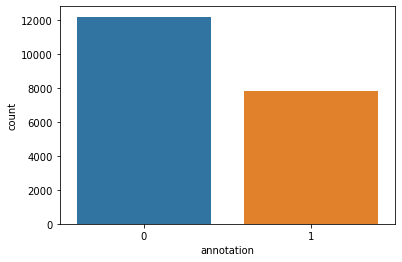

In [18]:
# is de dataset gebalanceerd?

# gebalanceerdheid controleren
sns.countplot(x='annotation',data=dataset)

dataset['annotation'].value_counts()

Not perfectly balanced. There are approximately 4350 samples more in the negative class than in the positive class. The classifier has a preference for the class without annotation (class 0).

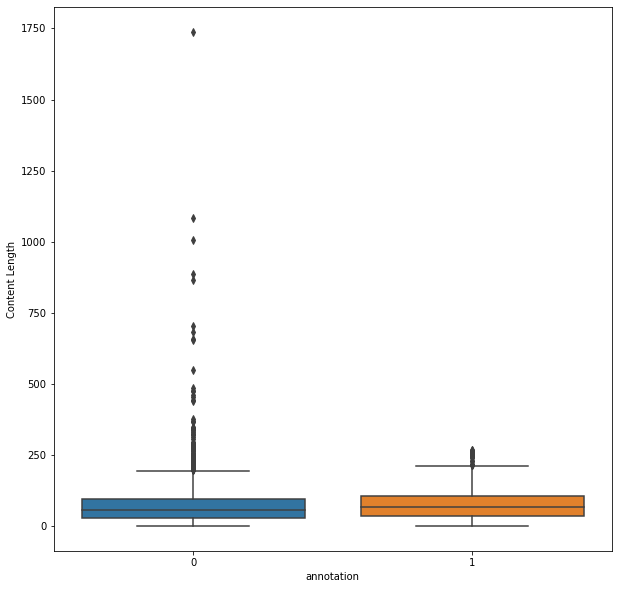

In [19]:
dataset['Content Length']=dataset['content'].apply(len)

plt.figure(figsize=(10,10))
sns.boxplot(x='annotation', y='Content Length', data=dataset)

In [20]:
dataset.corr()

,annotation,Content Length
annotation,1.000000,0.053249
Content Length,0.053249,1.000000


Correlation coefficient of 0.05 indicates that the relationship is positive and has very little, almost no correlation. This means that the annotation and the content length has no correlation.

### 2. Preprocessing van de tekst

- Kuis de teksten op: verwijder stopwoorden en niet-letters, zet alles om naar lowercase, ... 
- Pas stemming toe.

In [21]:
# Preprocessing van de tekst

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words


In [22]:
# Convert training and test set to bag of words
language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "  .." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Dominic Ho\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://tinyurl.com/these-hats-are-damn-tradition" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\Dominic Ho\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "  ." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Dominic Ho\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "  ...." looks like a filename, not markup. You should probably open

### 3. Omzetten naar bag-of-words

Maak gebruik van de CountVectorizer en TfidfTransformer om een bag-of-words model te creëren. 

Meer info: 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer



In [23]:
# Omzetten naar bag-of-words

# Make sparse features vectors 

# create instance 
count_vect = CountVectorizer()

# train the object on the training set
X_train_bag_of_words = count_vect.fit(X_train)

# apply  the function on train
X_train_bag_of_words = count_vect.transform(X_train)
# apply  the function on test
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)


  (0, 3317)	1
  (0, 5689)	1
  (0, 5979)	1
  (0, 7363)	1
  (1, 1673)	1
  (1, 3256)	1
  (1, 6575)	1
  (1, 8098)	1
  (1, 8588)	1
  (1, 9563)	1
  (1, 10611)	2
  (2, 659)	1
  (2, 1007)	1
  (2, 3336)	2
  (2, 4671)	1
  (2, 5689)	1
  (2, 5951)	2
  (2, 7283)	1
  (2, 7585)	1
  (2, 7908)	1
  (2, 8241)	1
  (2, 8648)	1
  (2, 9314)	1
  (2, 9558)	1
  (3, 391)	1
  :	:
  (14996, 7952)	1
  (14996, 9804)	1
  (14996, 10662)	1
  (14997, 8694)	1
  (14997, 11094)	1
  (14998, 2225)	1
  (14998, 3668)	1
  (14998, 6701)	1
  (14998, 8785)	1
  (14998, 9336)	1
  (14998, 9590)	1
  (14999, 491)	1
  (14999, 3968)	1
  (14999, 5781)	1
  (14999, 6340)	1
  (14999, 9140)	1
  (14999, 9684)	1
  (14999, 10801)	1
  (15000, 987)	1
  (15000, 1419)	1
  (15000, 3256)	3
  (15000, 3556)	1
  (15000, 4270)	1
  (15000, 5506)	1
  (15000, 7948)	1


In [24]:
print(X_train[0])

 like mani photo fb 


### 4. Trainen van de classifiers

Train drie verschillende classifiers op de bag-of-words data: naive bayes classifier, logistic regression classifier en een Support Vector Machine classifier.


In [25]:
# Train a Naive bayes classifier

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1)

In [26]:
# test Naive Bayes classifier

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      3053
           1       0.80      0.55      0.65      1947

    accuracy                           0.77      5000
   macro avg       0.78      0.73      0.74      5000
weighted avg       0.78      0.77      0.76      5000

[[2789  264]
 [ 876 1071]]
77.2


In [27]:
# train a logistic regression classifier
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [28]:
# test logistic classifier

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      3053
           1       0.76      0.86      0.81      1947

    accuracy                           0.84      5000
   macro avg       0.83      0.85      0.84      5000
weighted avg       0.85      0.84      0.84      5000

[[2536  517]
 [ 267 1680]]
84.32


In [29]:
# train a SVM
SVMlinear = svm.SVC(kernel='linear',C=0.1, probability=True)
SVMlinear.fit(X_train_tf, y_train)

SVC(C=0.1, kernel='linear', probability=True)

In [30]:
# test SVM
y_pred = SVMlinear.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


              precision    recall  f1-score   support

           0       0.69      0.92      0.79      3053
           1       0.72      0.34      0.47      1947

    accuracy                           0.69      5000
   macro avg       0.71      0.63      0.63      5000
weighted avg       0.70      0.69      0.66      5000

[[2797  256]
 [1276  671]]
69.36


The logistic regression has the highest accuracy rate of 84,32%.

### 5. Testen van de getrainde classifiers + uitvoeren van hyperparameter tuning

- Voer hyperparameter tuning uit via grid-search, random search of Bayes Optimization.
- Welke classifier heeft jouw voorkeur? Beargumenteer in de context van accuracy, f1-score en berekeningstijd.
- Bekijk enkele verkeerd geklassificeerde reviews. Is er een verklaring voor te vinden?


Voor het evalueren van de classifier gebruik je de volgende metrics: accuracy, f1 score en de ROC. Formuleer conclusies. Bijvoorbeeld naar de keuze toe van de classifier, interpretatie van de ROC of auROC. Toon enkele verkeerd geclassificeerde berichten en probeer te achterhalen waarom ze verkeerd geclassificeerd werden.

In [31]:
# hyperparameter tuning Naive Bayes - Grid Search

from sklearn.model_selection import GridSearchCV


model = MultinomialNB()
paramaters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

grid_search_nb = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search_nb = grid_search_nb.fit(X_train_tf, y_train)

best_accuracy = grid_search_nb.best_score_ 
best_parameters = grid_search_nb.best_params_  

print('Best accuracy : ', grid_search_nb.best_score_)
print('Best parameters :', grid_search_nb.best_params_  )

y_pred = grid_search_nb.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


Best accuracy :  0.7953489569462937
Best parameters : {'alpha': 0.001}
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3053
           1       0.75      0.77      0.76      1947

    accuracy                           0.81      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.81      0.81      0.81      5000

[[2549  504]
 [ 442 1505]]
81.08


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


In [33]:
# hyperparameter tuning Naive Bayes - Random Search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = MultinomialNB()
parameters = [
             {'alpha' : [0.001, 0.01, 0.1, 1, 10]}                                       
             ]

# random search zoeken, bv 20 willekeurig random searches
n_iter_search = 20

# cv = cross validatie
random_search_nb = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search_nb = random_search_nb.fit(X_train_tf, y_train)

best_accuracy = random_search_nb.best_score_ 
best_parameters = random_search_nb.best_params_  

print('Best accuracy : ', random_search_nb.best_score_)
print('Best parameters :',random_search_nb.best_params_  )

y_pred = random_search_nb.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best accuracy :  0.7770822392535821
Best parameters : {'alpha': 0.01}
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3053
           1       0.75      0.77      0.76      1947

    accuracy                           0.81      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.81      0.81      0.81      5000

[[2548  505]
 [ 445 1502]]
81.0


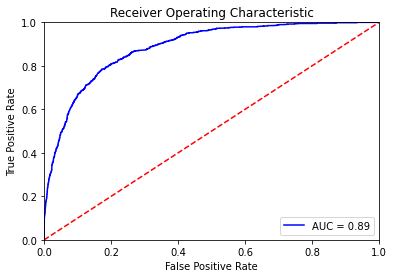

In [36]:
# ROC

import sklearn.metrics as metrics

probs = grid_search_nb.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
# hyperparameter tuning Logistic Regression - Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.01, 0.1, 1, 10, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},                                       
             ]


grid_search_lr = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 20,
                           n_jobs = -1,
                           verbose=5)
grid_search_lr = grid_search_lr.fit(X_train_tf, y_train)

best_accuracy = grid_search_lr.best_score_ 
best_parameters = grid_search_lr.best_params_  

print('Best accuracy : ', grid_search_lr.best_score_)
print('Best parameters :', grid_search_lr.best_params_  )

y_pred = grid_search_lr.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.6min finished


Best accuracy :  0.8636106524633821
Best parameters : {'C': 100, 'class_weight': None, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      3053
           1       0.76      0.89      0.82      1947

    accuracy                           0.85      5000
   macro avg       0.84      0.86      0.84      5000
weighted avg       0.86      0.85      0.85      5000

[[2493  560]
 [ 205 1742]]
84.7


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
# hyperparameter tuning Logistic Regression - Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : uniform(0.01, 20), 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

              

n_iter_search = 20

random_search_lr = RandomizedSearchCV(model, param_distributions=parameters,cv=20,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search_lr = random_search_lr.fit(X_train_tf, y_train)

best_accuracy = random_search_lr.best_score_ 
best_parameters = random_search_lr.best_params_  

print('Best accuracy : ', random_search_lr.best_score_)
print('Best parameters :',random_search_lr.best_params_  )

y_pred = random_search_lr.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Best accuracy :  0.8574778517532179
Best parameters : {'C': 18.042249491270713, 'class_weight': None, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3053
           1       0.77      0.88      0.82      1947

    accuracy                           0.85      5000
   macro avg       0.84      0.86      0.85      5000
weighted avg       0.86      0.85      0.85      5000

[[2536  517]
 [ 224 1723]]
85.18


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


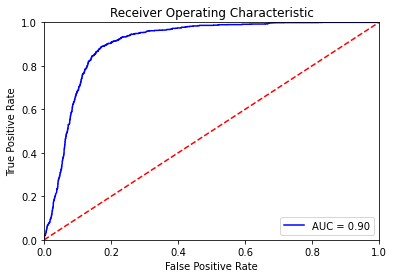

In [39]:
# ROC

import sklearn.metrics as metrics

probs = random_search_lr.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
# laten draaien
# hyperparameter tuning SVM - Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(probability=True)

paramaters = [ 
        {'kernel': ['linear'], 
         'C':  [0.1, 1, 10], 
         'class_weight': [None, 'balanced']},
        {'kernel': ['rbf', 'poly', 'sigmoid'], 
         'C': [0.1, 1, 10], 
         'gamma': [0.001, 0.01, 0.1, 0.2], 
         'class_weight': [None, 'balanced']},
]

grid_search_svm = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', 
                           cv = 2,
                           n_jobs = -1,
                           verbose =5,)

grid_search_svm = grid_search_svm.fit(X_train_tf, y_train)

best_accuracy = grid_search_svm.best_score_ 
best_parameters = grid_search_svm.best_params_  
print('Best accuracy : ', grid_search_svm.best_score_)
print('Best parameters :', grid_search_svm.best_params_  )


y_pred = grid_search_svm.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 2 folds for each of 78 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed: 42.1min finished


Best accuracy :  0.8006137759409857
Best parameters : {'C': 10, 'class_weight': None, 'gamma': 0.2, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3053
           1       0.79      0.92      0.85      1947

    accuracy                           0.87      5000
   macro avg       0.87      0.88      0.87      5000
weighted avg       0.88      0.87      0.88      5000

[[2581  472]
 [ 159 1788]]
87.38


In [44]:
# laten draaien
# hyperparameter tuning SVM - Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform


#svc trainen
model = SVC()

parameters = [
    {'kernel': ['linear'], 
     'C': uniform(0.01, 20), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']
    },
    {'kernel': ['rbf', 'poly', 'sigmoid'], 
     'C': uniform(0.01, 20), 
     'gamma': uniform(0.001, 0.2), 
     'degree': [2,3,4], 
     'class_weight': [None, 'balanced']}
]
 
n_iter_search = 20

random_search_svm = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search_svm = random_search_svm.fit(X_train_tf, y_train)

best_accuracy = random_search_svm.best_score_ 
best_parameters = random_search_svm.best_params_  

print('Best accuracy : ', random_search_svm.best_score_)
print('Best parameters :',random_search_svm.best_params_  )

y_pred = random_search_svm.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.5min finished


Best accuracy :  0.8356113073419971
Best parameters : {'C': 18.606927335765125, 'class_weight': None, 'degree': 4, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      3053
           1       0.74      0.90      0.81      1947

    accuracy                           0.84      5000
   macro avg       0.83      0.85      0.83      5000
weighted avg       0.85      0.84      0.84      5000

[[2442  611]
 [ 199 1748]]
83.8


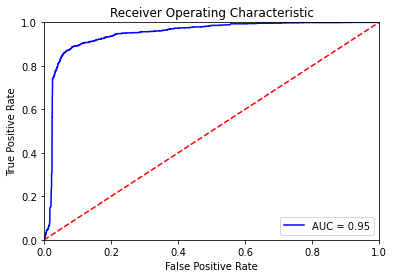

In [45]:
# ROC

import sklearn.metrics as metrics

probs = grid_search_svm.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In general if we compare the 3 classifiers, we can see that there are differences in scores. Based on the scores the order is as follows: SVM - Grid Search(87,38%), Logistic Regression (85,18%) and Naive Bayes (81,08%). Eventhough the SVM has the longest execution time, it is still the most suitable classifier due to the fact that the difference of accuracy is huge between the classifiers. Therefore it is also more reliable.

The ROC curve is a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. In this case, the highest AUC amounts 0.95 from the SVM (grid search) classifier. 

Toon enkele verkeerd geclassificeerde berichten en probeer te achterhalen waarom ze verkeerd geclassificeerd werden.

In [126]:
indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

In [127]:
wrong_predictions = dataset.iloc[indices,:]
wrong_predictions

,annotation,content
0,1,Get fucking real dude.
4,1,WTF are you talking about Men? No men thats n...
7,1,...go absolutely insane.hate to be the bearer ...
8,1,Lmao im watching the same thing ahaha. The ga...
14,1,damn it i totally forgot that one!
...,...,...
4987,1,lol ur whale penis
4988,1,I know there's a bottle of bourbon in that hou...
4991,1,DAMN.
4995,1,ouch that sucks..


As we can see from the wrong classified predictions, we could say that words with spelling mistakes and slang words are often used.